In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab inline
import os.path as op
import sys
import os

import json
import skimage.color
import skimage.filters
import morphsnakes as ms

Populating the interactive namespace from numpy and matplotlib


## Import openslide

In [3]:
pth = op.expanduser(r"~\Downloads/openslide-win64-20171122/bin")
# pth = op.expanduser(r"~\projects\scaffan\devel\knihovny")
# pth = op.expanduser(r"~\Miniconda3\envs\lisa36\Library\bin")
sys.path.insert(0, pth)
orig_PATH = os.environ["PATH"]
os.environ["PATH"] = pth + ";" + os.environ["PATH"]

In [4]:
# import numpy as np
import openslide as opsl

# Work with image data

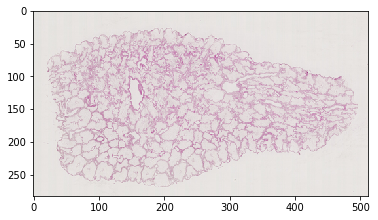

In [5]:
pth = r"E:/data/scaffold/Hamamatsu/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi"
imsl = opsl.OpenSlide(pth)
imthumb = imsl.get_thumbnail((512, 512))

plt.imshow(imthumb)

In [6]:
imsl.level_dimensions

((90112, 49920),
 (45056, 24960),
 (22528, 12480),
 (11264, 6240),
 (5632, 3120),
 (2816, 1560),
 (1408, 780),
 (704, 390),
 (352, 195))

In [7]:
imsl.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)

## Resolution

In [8]:
pm = imsl.properties
resolution_unit = pm.get("tiff.ResolutionUnit")
resolution_x= pm.get("tiff.XResolution")
resolution_y= pm.get("tiff.YResolution")
print("Resolution {}x{} pixels/{}".format(resolution_x, resolution_y, resolution_unit))

Resolution 44005x43953 pixels/centimeter


In [9]:
imsl.dimensions

(90112, 49920)

In [10]:
# my annotataion area
kwargs_annotation_area = dict(
    location = (19000, 10000),
    level = 4,
    size = (1200, 900),
)

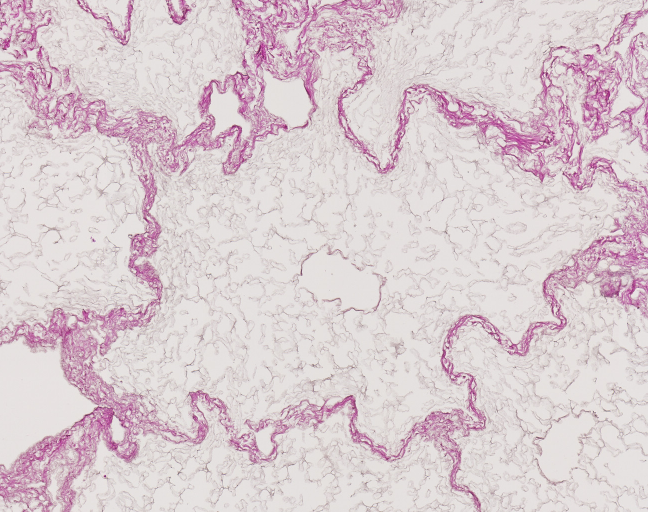

In [11]:
# one lobulus
kwargs_one_lobulus = dict(
    location = (44200, 27000),
    level = 3,
    size = (648, 512),
)
imsl.read_region(**kwargs_one_lobulus)

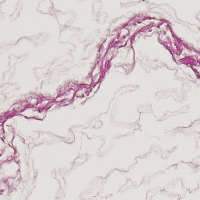

In [12]:
# one lobulus
kwargs_sample0 = dict(
    location = (10500, 21000),
    level = 2,
    size = (200, 200),
)
imsl.read_region(**kwargs_sample0)

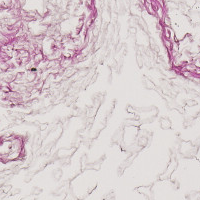

In [13]:
# one lobulus
kwargs_sample1 = dict(
    location = (13000, 15000),
    level = 2,
    size = (200, 200),
)
imsl.read_region(**kwargs_sample1)

In [17]:
# one lobulus
kwargs_sample_bigger = dict(
    location = (13000, 15000),
    level = 2,
    size = (3200, 3200),
)
reg = imsl.read_region(**kwargs_sample_bigger)
print(reg)

<PIL.Image.Image image mode=RGBA size=3200x3200 at 0x155837AD828>


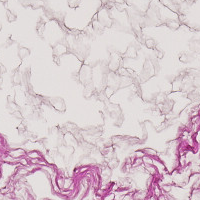

In [18]:
# one lobulus
kwargs_sample2 = dict(
    location = (26000, 15000),
    level = 2,
    size = (200, 200),
)
imsl.read_region(**kwargs_sample2)

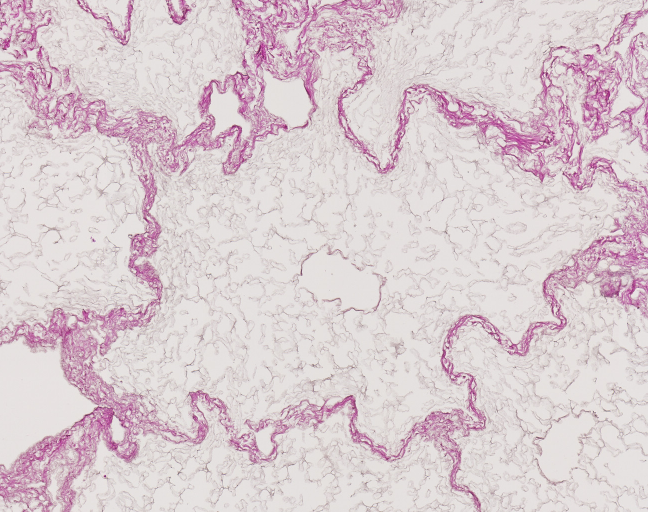

In [19]:
imcr = imsl.read_region(**kwargs_one_lobulus)
imcr

In [20]:
im = np.asarray(imcr)

In [21]:
def circle_level_set(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    return u

In [22]:
center = (47000, 29200)

def get_image_with_center(imsk, center, level=3, size=None, as_gray=True):
    if size is None:
        size = np.array([800, 800])
    size2 = (size/2).astype(int) 
#     level = 3

    offset = size2 * imsl.level_downsamples[level]
    location = (np.asarray(center) - offset).astype(np.int)

    imcr = imsl.read_region(location, level=level, size=size)
    im = np.asarray(imcr)
    if as_gray:
        im = skimage.color.rgb2gray(im)
    return im

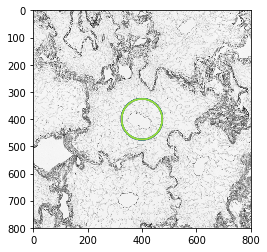

In [23]:

imsl
center = (47000, 29200)
size = np.array([800, 800])
size2 = (size/2).astype(int) 
level = 3

offset = size2 * imsl.level_downsamples[level]
location = (np.asarray(center) - offset).astype(np.int)

imcr = imsl.read_region(location, level=level, size=size)
im = np.asarray(imcr)
imgr = skimage.color.rgb2gray(im)
circle = circle_level_set(imgr.shape, size2, 75, scalerow=0.75)
plt.imshow(imgr, cmap="gray")
plt.contour(circle)

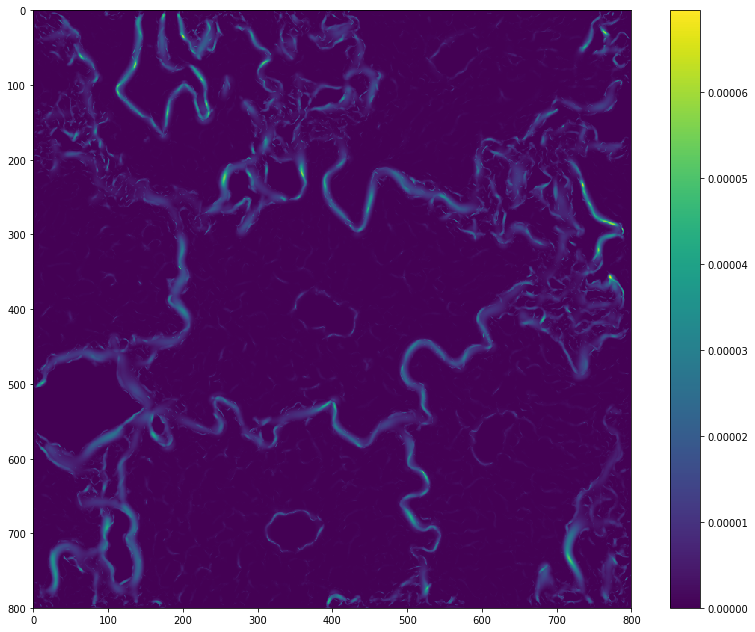

In [24]:
im_gradient0 = skimage.filters.frangi(imgr)

# im_gradient = ms.gborders(imgr, alpha=1000, sigma=2)
plt.figure(figsize=(14,11))
imshow(im_gradient0)
colorbar()

dtype('float64')

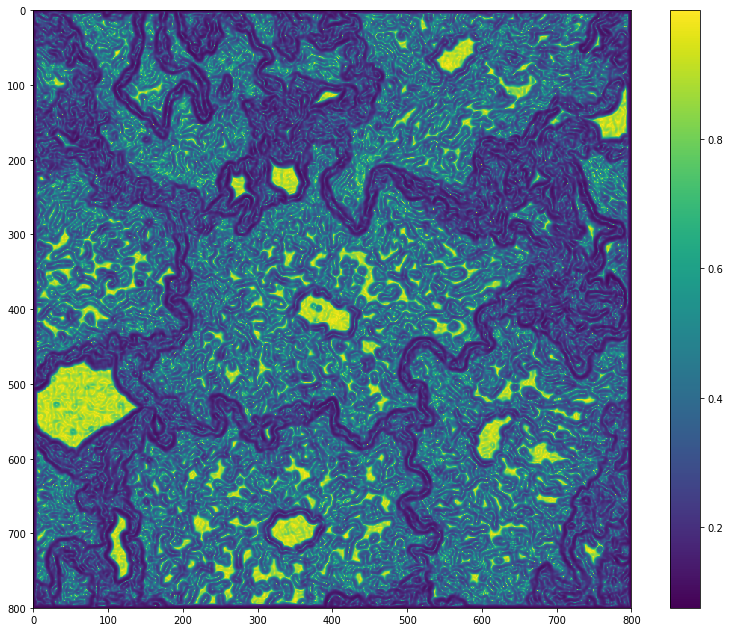

In [25]:

im_gradient1 = ms.gborders(imgr, alpha=1000, sigma=2)
plt.figure(figsize=(14,11))
imshow(im_gradient1)
colorbar()
im_gradient1.dtype

In [26]:

im_gradient = im_gradient1 - (im_gradient0 * 10000)

In [27]:

# im_gradient = 0.7 - (im_gradient0 * 50000)

dtype('float64')

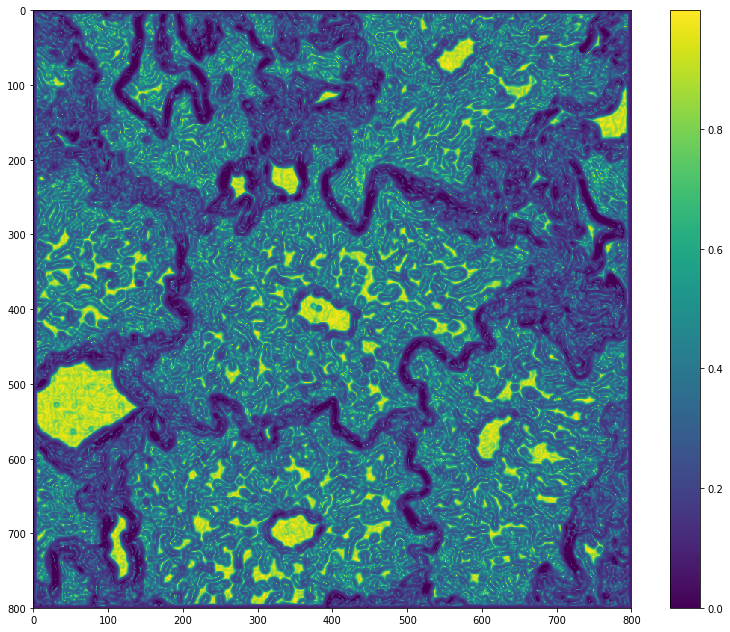

In [28]:
im_gradient[im_gradient < 0] = 0

plt.figure(figsize=(14,11))
imshow(im_gradient) 
colorbar()
im_gradient.dtype

In [29]:
# im_gradient = skimage.filters.frangi(imgr)

# im_gradient = ms.gborders(imgr, alpha=1000, sigma=2)
# plt.figure(figsize=(14,11))
# imshow(im_gradient)
# colorbar()

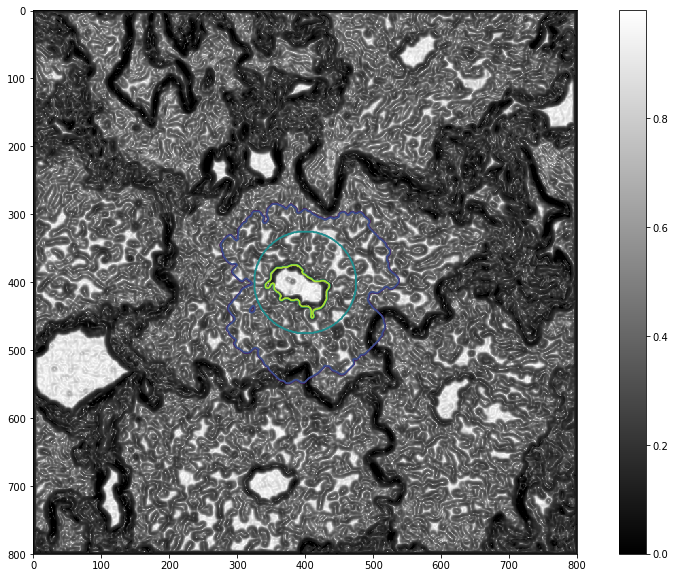

In [30]:

circle = circle_level_set(imgr.shape, size2, 75, scalerow=0.75)
mgac = ms.MorphGAC(im_gradient, smoothing=2, threshold=0.3, balloon=-1)
mgac.levelset = circle.copy()
mgac.run(iterations=100)
inner = mgac.levelset.copy()


# mgac = ms.MorphGAC(im_gradient, smoothing=2, threshold=0.15, balloon=+1)
mgac = ms.MorphACWE(im_gradient, smoothing=2, lambda1=0.5, lambda2=30.0)
mgac.levelset = circle.copy()
mgac.run(iterations=100)
outer = mgac.levelset.copy()

# circle = circle_level_set(imgr.shape, (200, 200), 75, scalerow=0.75)

plt.figure(figsize=(15,10))
plt.imshow(im_gradient, cmap="gray")
plt.colorbar()
plt.contour(circle + inner + outer )
# plt.figure(figsize=(15,10))
# plt.imshow(imgr, cmap="gray")
# ms.evolve(mgac, num_iters=110, background=imgr)

# # MorphGAC. 
# ms.MorphGAC(imgr_frangi, iterations=100, 
#                                          init_level_set=init_ls,
#                                          smoothing=2, threshold=0.3,
#                                          balloon=-1)#, iter_callback=callback)

## Setup with ACWE

In [31]:
help(ms.MorphACWE)

Help on class MorphACWE in module morphsnakes:

class MorphACWE(builtins.object)
 |  Morphological ACWE based on the Chan-Vese energy functional.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, smoothing=1, lambda1=1, lambda2=1, levelset=None, smooth_map=None, seeds=None)
 |      Create a Morphological ACWE solver.
 |      
 |      Parameters
 |      ----------
 |      data : ndarray
 |          The image data.
 |      smoothing : scalar
 |          The number of repetitions of the smoothing step (the
 |          curv operator) in each iteration. In other terms,
 |          this is the strength of the smoothing. This is the
 |          parameter µ.
 |      lambda1, lambda2 : scalars
 |          Relative importance of the inside pixels (lambda1)
 |          against the outside pixels (lambda2).
 |      smooth_map: array-like
 |          The smoothing parameter map. Parameter can be different in each data
 |          area.
 |      seeds: array-like, same shape as input data


In [32]:

# im_gradient = im_gradient0

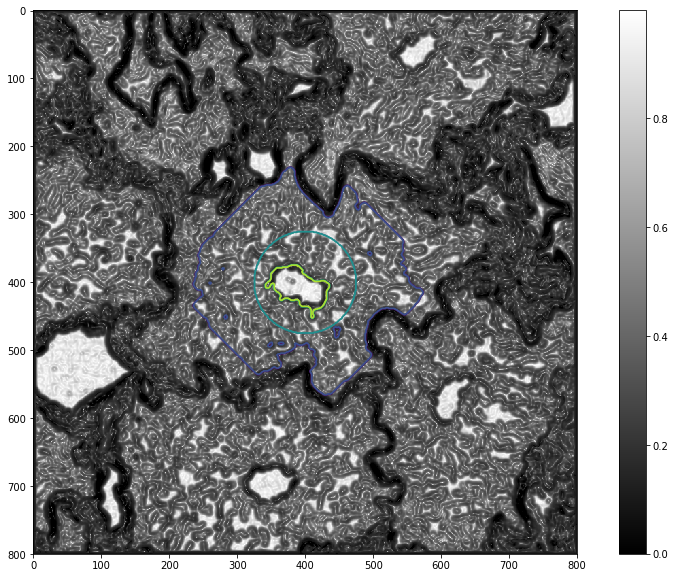

In [33]:


#     logging.info('Running: example_starfish (MorphGAC)...')
    
    # Load the image.
#     imgcolor = imread(PATH_IMG_STARFISH) / 255.0
#     img = rgb2gray(imgcolor)
    
    # g(I)
# gimg = ms.inverse_gaussian_gradient(imgr_frangi, alpha=1000, sigma=2)
    
# Initialization of the level-set.
# init_ls = circle_level_set(imgr_frangi.shape, (200, 200), 85)

# Callback for visual plotting
# callback = ms.visual_callback_2d(imgcolor)
# gb = ms.gborders(imgr_frangi, alpha=1000, sigma=2)

circle = circle_level_set(imgr.shape, size2, 75, scalerow=0.75)
# mgac = ms.MorphGAC(im_gradient, smoothing=2, threshold=0.3, balloon=-1)
# mgac.levelset = circle.copy()
# mgac.run(iterations=100)
# inner = mgac.levelset.copy()


# mgac = ms.MorphGAC(im_gradient, smoothing=2, threshold=0.2, balloon=+1)
# mgac = ms.MorphACWE(im_gradient0, smoothing=2, lambda1=50.5, lambda2=1.0) # tohle pěkně obemkne centrální žílu
mgac = ms.MorphACWE(im_gradient0, smoothing=2, lambda1=0.5, lambda2=1.0)
mgac.levelset = circle.copy()
mgac.run(iterations=100)
outer = mgac.levelset.copy()

# circle = circle_level_set(imgr.shape, (200, 200), 75, scalerow=0.75)

plt.figure(figsize=(15,10))
plt.imshow(im_gradient, cmap="gray")
plt.colorbar()
plt.contour(circle + inner + outer )
# plt.figure(figsize=(15,10))
# plt.imshow(imgr, cmap="gray")
# ms.evolve(mgac, num_iters=110, background=imgr)

# # MorphGAC. 
# ms.MorphGAC(imgr_frangi, iterations=100, 
#                                          init_level_set=init_ls,
#                                          smoothing=2, threshold=0.3,
#                                          balloon=-1)#, iter_callback=callback)

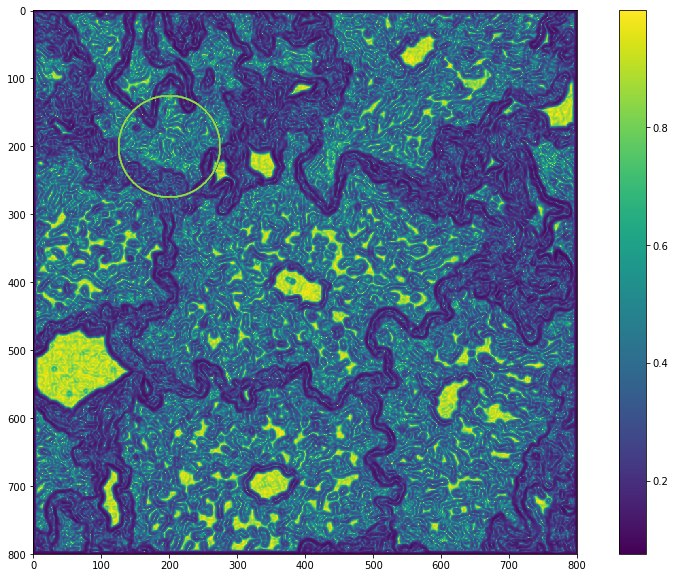

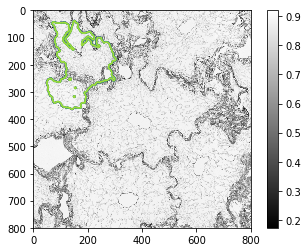

In [34]:

import morphsnakes as ms
#     logging.info('Running: example_starfish (MorphGAC)...')
    
    # Load the image.
#     imgcolor = imread(PATH_IMG_STARFISH) / 255.0
#     img = rgb2gray(imgcolor)
    
    # g(I)
# gimg = ms.inverse_gaussian_gradient(imgr_frangi, alpha=1000, sigma=2)
    
# Initialization of the level-set.
# init_ls = circle_level_set(imgr_frangi.shape, (200, 200), 85)

# Callback for visual plotting
# callback = ms.visual_callback_2d(imgcolor)
# gb = ms.gborders(imgr_frangi, alpha=1000, sigma=2)
gb = ms.gborders(imgr, alpha=1000, sigma=2)
mgac = ms.MorphGAC(gb, smoothing=2, threshold=0.3, balloon=+1)

mgac.levelset = circle_level_set(im_gradient0.shape, (200, 200), 75, scalerow=0.75)
plt.figure(figsize=(15,10))
plt.imshow(gb)
plt.colorbar()
plt.contour(mgac.levelset)
mgac.run(iterations=110)
plt.figure()
plt.imshow(imgr, cmap="gray")
plt.colorbar()
plt.contour(mgac.levelset)
outer = mgac.levelset
# ms.evolve(mgac, num_iters=110, background=imgr)

# # MorphGAC. 
# ms.MorphGAC(imgr_frangi, iterations=100, 
#                                          init_level_set=init_ls,
#                                          smoothing=2, threshold=0.3,
#                                          balloon=-1)#, iter_callback=callback)

# Lobulus area analysis

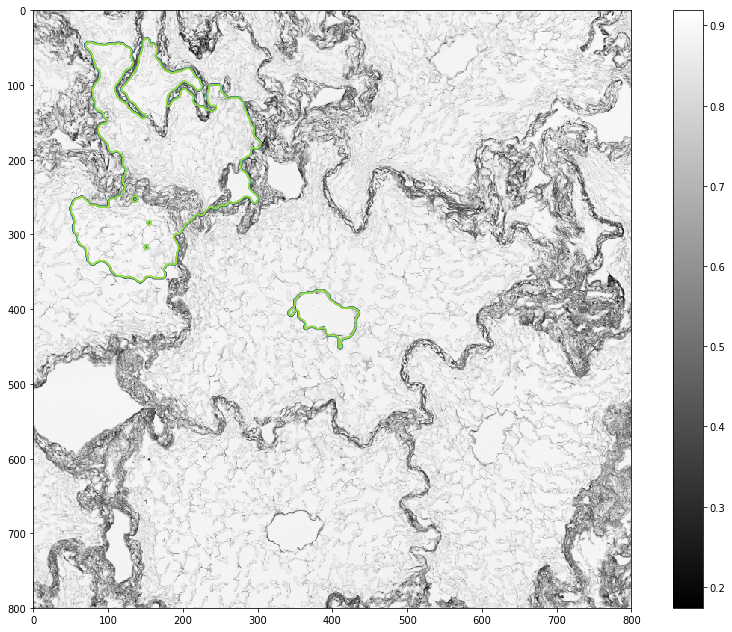

In [35]:
lobulus = inner + outer

plt.figure(figsize=(15,11))
plt.imshow(imgr, cmap="gray")
plt.colorbar()
plt.contour(lobulus)


## Transfer segmentation to different level

In [36]:
new_level = int(1)
location = kwargs_one_lobulus["location"]
former_level = kwargs_one_lobulus["level"]
former_size = kwargs_one_lobulus["size"]


imsl.level_downsamples

scale_factor = imsl.level_downsamples[former_level] / imsl.level_downsamples[new_level]
new_size = (np.asarray(former_size) * scale_factor).astype(np.int)




In [37]:
newimcr = imsl.read_region(location, new_level, new_size)

new_lobulus = skimage.transform.resize(lobulus, new_size, mode="reflect")

C:\Users\miros\Miniconda3\envs\scaffan\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


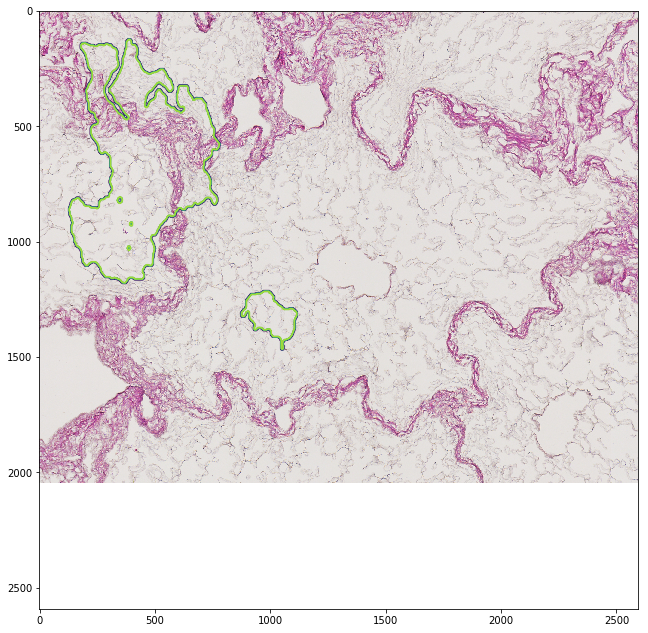

In [38]:

plt.figure(figsize=(15,11))
plt.imshow(newimcr)
# plt.colorbar()
plt.contour(new_lobulus)

## Binarization

In [39]:

newimgr = skimage.color.rgb2gray(np.array(newimcr))
display(newimgr.shape)
display(new_lobulus.shape)
lobulus_area = newimgr.copy()
lobulus_area[new_lobulus!=1] = 0
plt.imshow(lobulus_area, cmap='gray')
plt.colorbar()

(2048, 2592)

(2592, 2048)

ValueError: operands could not be broadcast together with shapes (2048,2592) (2592,2048) 

In [ ]:
plt.hist(newimgr[new_lobulus==1])

In [ ]:
threshold = skimage.filters.threshold_otsu(newimgr[new_lobulus==1])
threshold

In [ ]:
thrdata = newimgr[new_lobulus == 1]
import skimage.filters as skfi
skfi.threshold_niblack(thrdata)

In [ ]:
thrdata = newimgr[new_lobulus == 1]
import skimage.filters as skfi
threshold = skfi.threshold_li(thrdata)
threshold

In [ ]:
imthr = (lobulus_area < threshold)
imthr[new_lobulus != 1] = 0

In [ ]:
view = [slice(1000, 1500), slice(1500, 2000)]

In [ ]:
plt.figure(figsize=(16,11))
plt.imshow(imthr[view])

In [ ]:
plt.figure(figsize=(16,11))
plt.imshow(imthr)

In [ ]:

image = newimgr#[view]
plt.figure(figsize(15, 10))
plt.imshow(image)

## Skeletonization

In [ ]:
from skimage.morphology import medial_axis, skeletonize, skeletonize_3d

data = imthr[view]

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(data)
skeleton3d = skeletonize_3d(data)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, axes = plt.subplots(5, 1, figsize=(12, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[4].imshow(newimgr[view], cmap=plt.cm.gray, interpolation='nearest')
ax[4].set_title('original')
ax[4].axis('off')

ax[0].imshow(data, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='magma', interpolation='nearest')
ax[1].contour(data, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton3d, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('skeletonize_3d')
ax[3].axis('off')

fig.tight_layout()
plt.show()

## Texture analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

METHOD = 'uniform'
plt.rcParams['font.size'] = 9



### LBP

In [ ]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


# image = data.load('brick.png')
image = newimgr[view]
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(ymax=np.max(counts[:-1]))
    ax.set_xlim(xmax=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

In [ ]:
# settings for LBP
radius = 2
n_points = 8 * radius


def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


sample0 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample0)))
sample1 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample1)))
sample2 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample2)))
# brick = data.load('brick.png')
# grass = data.load('grass.png')
# wall = data.load('rough-wall.png')

refs = {
    'sample0': local_binary_pattern(sample0, n_points, radius, METHOD),
    'sample1': local_binary_pattern(sample1, n_points, radius, METHOD),
    'sample2': local_binary_pattern(sample2, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: sample0, rotated: 30deg, match result: ',
      match(refs, rotate(sample0, angle=30, resize=False)))
print('original: sample1, rotated: 70deg, match result: ',
      match(refs, rotate(sample1, angle=70, resize=False)))
print('original: sample2, rotated: 145deg, match result: ',
      match(refs, rotate(sample2, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(15, 10))
plt.gray()

ax1.imshow(sample0)
ax1.axis('off')
hist(ax4, refs['sample0'])
ax4.set_ylabel('Percentage')

ax2.imshow(sample1)
ax2.axis('off')
hist(ax5, refs['sample1'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(sample2)
ax3.axis('off')
hist(ax6, refs['sample2'])

plt.show()

In [ ]:
def texture_segmentation(image, decision_function, models, tile_size):
    output = np.asarray(image, dtype=np.int8)
    for x0 in range(0, image.shape[0], tile_size[0]):
        for x1 in range(0, image.shape[1], tile_size[1]):
            sl = [
                slice(x0, x0 + tile_size[0]),
                slice(x1, x1 + tile_size[1])
            ]
            output[sl] = decision_function(models, image[sl])
            
    return output
            
    

In [ ]:
sample0 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample0)))
sample1 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample1)))
sample2 = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample2)))
sample_bigger = skimage.color.rgb2gray(np.asarray(imsl.read_region(**kwargs_sample_bigger)))
# brick = data.load('brick.png')
# grass = data.load('grass.png')
# wall = data.load('rough-wall.png')

models = {
    1: local_binary_pattern(sample0, n_points, radius, METHOD),
#     2: local_binary_pattern(sample1, n_points, radius, METHOD),
    3: local_binary_pattern(sample2, n_points, radius, METHOD)
}

In [ ]:
seg = texture_segmentation(sample_bigger, match, models, kwargs_sample0["size"])
figure()
imshow(sample_bigger)
contour(seg)
import skimage.color
figure()
imshow(skimage.color.label2rgb(seg, sample_bigger))

In [ ]:
import skimage.morphology
# help(skimage.morphology.label)
skimage

In [ ]:
meshgrid([1,5,10], [1,5,10])

# Read annotation from json

In [ ]:
def read_annotations(pth):
    fn = pth + ".ndpa.json"
    with open(fn) as f:
        data = json.load(f)
    return data

In [ ]:
annotations = read_annotations(pth)
len(annotations)

In [ ]:
def plot_annotations(annotations):
    for annotation in annotations:
        plt.hold(True)
        plt.plot(annotation["x"], annotation["y"], c=annotation["color"])
plot_annotations(annotations)

# Combine image data with annotation

In [ ]:
import pandas as pd
df = pd.DataFrame(annotations[0])
location0 = (df.x.min(), -df.y.max())
location0

In [ ]:
level = 6
display(imsl.level_dimensions)
imcr = imsl.read_region(location0, level ,(1000,1000))
imcr